In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark import SparkConf, SparkContext
import utils

In [2]:
conf = SparkConf().setMaster("local").setAppName("minute_water_classification")
sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

In [3]:
df = sqlContext.read.load("../datasets/minute_weather.csv.gz", 
                          format="com.databricks.spark.csv",
                          header=True, inferSchema="true")

In [4]:
df.count()

1587257

In [5]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [6]:
filteredDF.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.830161410269,3.0517165528304218,905.0,929.5
air_temp,158726,61.8515891536367,11.83356921064173,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905971,0.0,359.0
avg_wind_speed,158680,2.7752148979077846,2.0576239697426213,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838614,0.0,359.0
max_wind_speed,158680,3.400557726241582,2.4188016208098935,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784639,0.0,359.0
min_wind_speed,158680,2.1346641038568777,1.742112505242431,0.0,31.6


In [7]:
# Let's calculate how many values of rain accumulation and duration are 0
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count()

157812

In [8]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count()

157237

In [9]:
# these features have 0 in all their data
workingDF = filteredDF.drop("rain_accumulation").drop("rain_duration").drop("hpwren_timestamp")

In [10]:
# missing values
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [11]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [12]:
"""
We do not want to include rowID since it is the row number. 
The minimum wind measurements have a high correlation to the 
average wind measurements, so we will not include them either.
Let's create an array of the columns we want to combine, 
and use VectorAssembler to create the vector column
"""
featuresUsed = ["air_pressure", "air_temp", 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed', "relative_humidity"]

assembler = VectorAssembler(inputCols = featuresUsed, outputCol = "features_unscaled")
assembled = assembler.transform(workingDF)

In [13]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True,
                       withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

We are going to use a elbow method to know what is the best *k* to train our 
K-means algorithm, this method uses the sum-of-squared error (WSSE).

In [14]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
# persist is a method that allows the computer to keep the data in memory
elbowset.persist()

DataFrame[features: vector]

In [15]:
clusters = range(2,31)
wseeList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 114998.41184838083 
Training for cluster size 3 
......................WSSE = 103418.48137970833 
Training for cluster size 4 
......................WSSE = 94576.72056439618 
Training for cluster size 5 
......................WSSE = 88020.14140715593 
Training for cluster size 6 
......................WSSE = 84758.39420626331 
Training for cluster size 7 
......................WSSE = 81667.9205294559 
Training for cluster size 8 
......................WSSE = 78470.81091255232 
Training for cluster size 9 
......................WSSE = 77119.20578473834 
Training for cluster size 10 
......................WSSE = 73742.99385679307 
Training for cluster size 11 
......................WSSE = 72889.45468940184 
Training for cluster size 12 
......................WSSE = 72585.971235329 
Training for cluster size 13 
......................WSSE = 69411.7508316892 
Training for cluster size 14 
......................WSSE = 67287.211435374

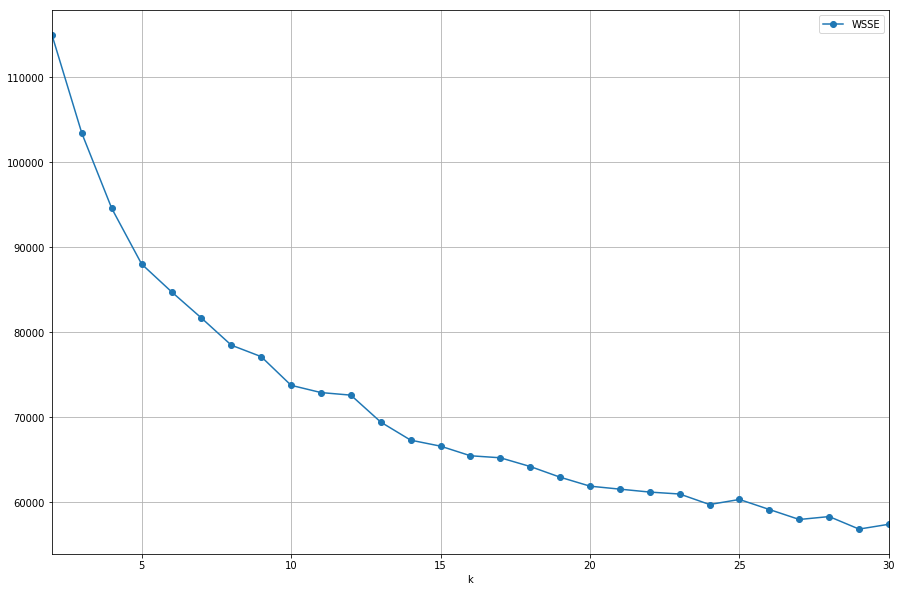

In [16]:
# let's plot the results calling the eblow_plot
utils.elbow_plot(wseeList, clusters)

From the last analysis we saw that the best k is the between 10-15.

In [17]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [99]:
kmeans =  KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
# the next line applies the model to the data
transformed = model.transform(scaledDataFeat)

In [38]:
type(model)

pyspark.ml.clustering.KMeansModel

Once the model is trained we can know the center measurements of each cluster.

In [103]:
centers = model.clusterCenters()
print("centers, centroids associated to the k's {}".format(len(centers)))

centers, centroids associated to the k's 12


In [105]:
centers

[array([-0.68257713, -0.90277204,  0.31614625, -0.56699566,  0.44621499,
        -0.56593102,  1.25532752]),
 array([-1.24916263, -0.80418386,  0.45104311,  2.04071659,  0.54106365,
         2.00020098,  0.85011183]),
 array([ 1.38348943, -0.0674317 , -1.14002539, -0.10866011, -0.99906695,
        -0.0895567 , -0.9927704 ]),
 array([ 0.25010579,  0.33423841,  1.88912287, -0.64921659, -1.55161295,
        -0.57407704, -0.30155493]),
 array([-0.19470501,  0.8630015 , -1.30772305, -0.58194769, -1.16593951,
        -0.59773715, -0.6275384 ]),
 array([-0.63653848, -1.2414811 ,  0.39751597,  0.64790878,  0.50087409,
         0.62768503,  1.34966966]),
 array([ 1.18863707, -0.25246924, -1.15405148,  2.09060321, -1.05197228,
         2.20727868, -1.13205199]),
 array([ 0.77331407, -0.87237737,  0.89311844, -0.48624935,  1.11681337,
        -0.45387827,  0.72050457]),
 array([-0.21032102,  0.62304291,  0.4021356 ,  0.66099689,  0.51081808,
         0.60238618, -0.17444294]),
 array([ 0.19494343

In [101]:
P = utils.pd_centers(featuresUsed, centers)

**We are going to create parallel plots of clusters and analysis**, a good way
to visualize multi-dimensional data. Each line plots the centroid of a cluster,
and all of the features plotted together. 

## Dry days

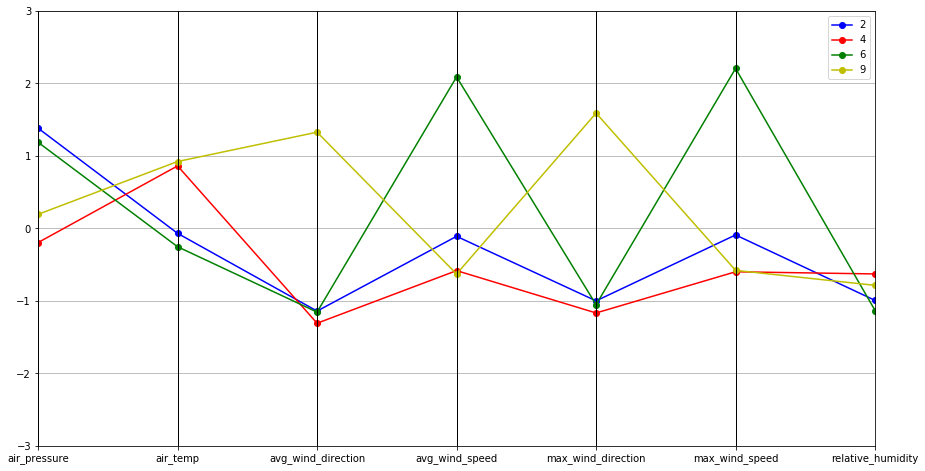

In [106]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

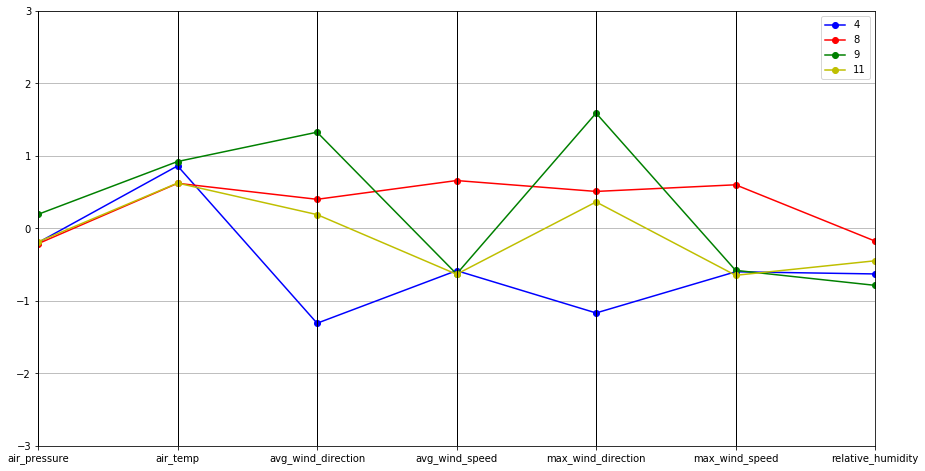

In [22]:
utils.parallel_plot(P[P["air_temp"] > 0.5], P)

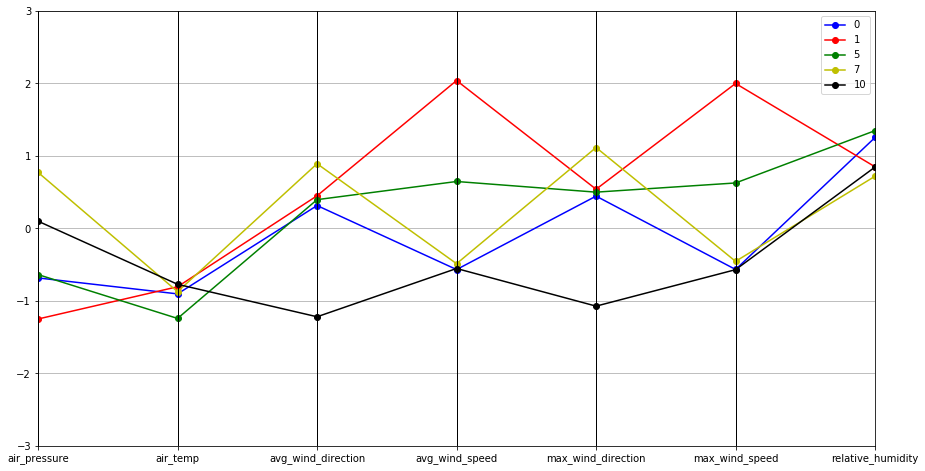

In [23]:
utils.parallel_plot(P[(P["relative_humidity"] > 0.5) & (P["air_temp"] < 0.5)], P)

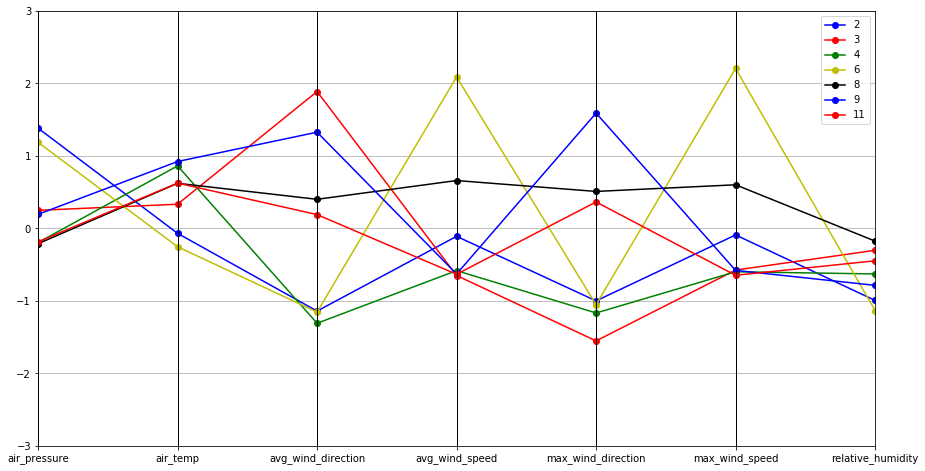

In [98]:
utils.parallel_plot(P[(P["relative_humidity"] < 0.5)], P)

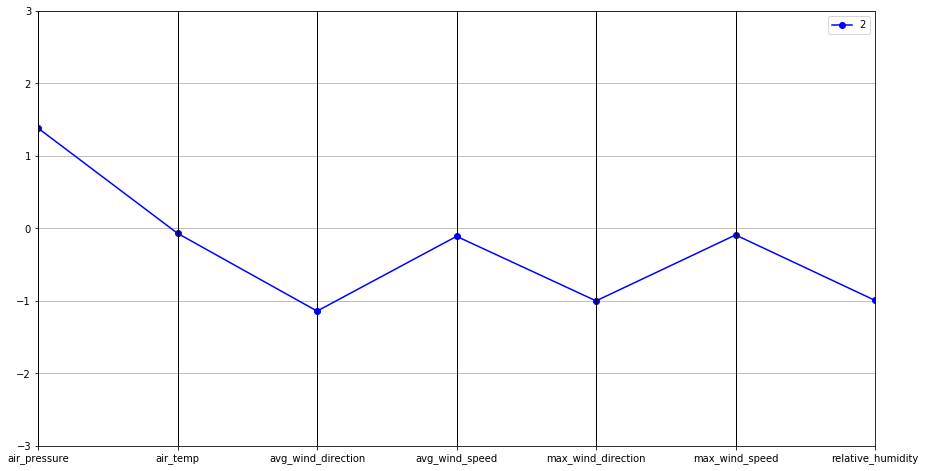

In [24]:
utils.parallel_plot(P.iloc[[2]], P)

What percentage of samples have 0 for rain_accumulation?

In [25]:
(157812 / 1587257) * 100

9.942435283007098

In [26]:
(157812 / 158726) * 100

99.42416491312073

If we wanted to create a data subset by taking every 5th sample instead of every 10th sample, how many samples would be in that subset?

In [27]:
filteredDF = df.filter((df.rowID % 5) == 0)
filteredDF.count()

317452

Just by looking at the values for the cluster centers, which cluster contains samples with the lowest relative humidity?

In [28]:
import pandas as pd
ok = pd.DataFrame(pd.Series(transformed.toPandas().iloc[:,0].values.tolist())).head()
#transformed.toPandas().iloc[:,0].values

In [29]:
featuresUsed

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

In [90]:
# set the data dimensionality as a parameter:
dimensionality = 7
cluster_2 = transformed.drop('prediction').rdd.map(lambda x: [float(x[0][i]) for i in range(dimensionality)]).toDF(schema=['x'+str(i) for i in range(dimensionality)])
type(cluster_2)

pyspark.sql.dataframe.DataFrame

In [91]:
cluster_2.columns

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

In [92]:
cluster_2 = cluster_2.selectExpr("x0 as air_pressure", "x1 as air_temp", "x2 as avg_wind_direction", 
                     "x3 as avg_wind_speed", "x4 as max_wind_direction", "x5 as max_wind_speed",
                     "x6 as relative_humidity")

In [93]:
cluster_2.describe("relative_humidity").show()

+-------+--------------------+
|summary|   relative_humidity|
+-------+--------------------+
|  count|              158680|
|   mean|1.105512028166524...|
| stddev|  1.0000000000000013|
|    min| -1.7817926237695338|
|    max|  1.7324241572801005|
+-------+--------------------+



In [94]:
data = pd.concat([cluster_2.toPandas(), transformed.select("prediction").toPandas()], axis=1)

In [95]:
data.loc[data.relative_humidity == data.relative_humidity.min()]

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
143975,-0.763645,1.066909,0.963955,-0.425352,1.011744,-0.537687,-1.781793,9
143977,-0.763645,0.945210,1.310309,-0.571151,1.368685,-0.620372,-1.781793,9
143978,-0.763645,0.838724,1.425761,-0.862750,1.585013,-0.909772,-1.781793,9
143981,-0.763645,0.717026,1.520221,-0.862750,1.682361,-0.909772,-1.781793,9


In [79]:
cluster_2.select('relative_humidity').rdd.min()[0]

-1.7817926237695338

In [80]:
cluster_2.filter(cluster_2['relative_humidity'] == cluster_2.select('relative_humidity').rdd.min()[0]).show()

+-------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+
|       air_pressure|          air_temp|avg_wind_direction|     avg_wind_speed|max_wind_direction|     max_wind_speed|  relative_humidity|
+-------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+
|-0.7636454592160266| 1.066908983162829|0.9639550147879717|-0.4253522075839613|1.0117435631159601|-0.5376868094730205|-1.7817926237695338|
|-0.7636454592160266|0.9452104346668073| 1.310309161350825|-0.5711514422407781|1.3686850089463143|-0.6203723833040128|-1.7817926237695338|
|-0.7636454592160266|0.8387242047327877|1.4257605435384428|-0.8627499115544119|1.5850131579344076|-0.9097718917124855|-1.7817926237695338|
|-0.7636454592160266|0.7170256562367662| 1.520220765328312|-0.8627499115544119|1.6823608249790496|-0.9097718917124855|-1.7817926237695338|
+-------------------+------

In [ ]:
utils.parallel_plot(P[P["relative_humidity"] < -0.5], P)

In [ ]:
P.sort_values(by=["relative_humidity"])

In [ ]:
utils.parallel_plot(P.iloc[[7,8,11]], P)

In [ ]:
kmeans =  KMeans(k=20, seed=1)
model = kmeans.fit(scaledDataFeat)
# the next line applies the model to the data
transformed = model.transform(scaledDataFeat)

In [ ]:
centers = model.clusterCenters()
P = utils.pd_centers(featuresUsed, centers)

In [ ]:
P[(P.relative_humidity == P.relative_humidity.min()) & (P.relative_humidity == P.max_wind_speed.max())]

In [ ]:
transformed.toPandas()

## References

+ https://stackoverflow.com/questions/47130299/pyspark-ml-get-kmeans-cluster-statistics/47156822